In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report

# Загрузка данных
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=ToTensor()
)

BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 92975387.93it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63957599.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31173165.22it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1345756.48it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
# Целевое значение
next(iter(train_dataloader))[1]


tensor([3, 6, 8, 5, 0, 0, 4, 5, 8, 1, 6, 7, 9, 7, 5, 7, 1, 6, 6, 1, 5, 8, 2, 9,
        0, 5, 8, 6, 3, 2, 5, 3, 2, 3, 2, 9, 7, 3, 6, 0, 8, 8, 8, 2, 9, 1, 7, 2,
        5, 5, 9, 9, 2, 7, 1, 0, 7, 8, 7, 9, 9, 1, 8, 6])

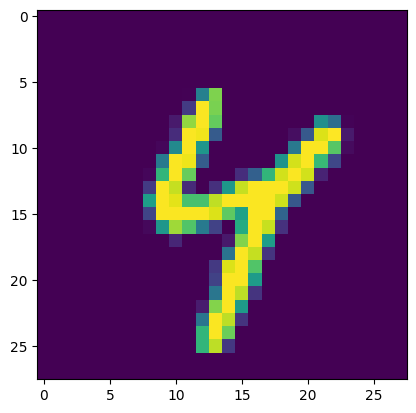

In [3]:
# Torch tensor
next(iter(train_dataloader))[0].shape

for_show = next(iter(train_dataloader))[0]
plt.imshow(for_show.numpy()[0][0])

class IsOne(torch.nn.Module):
    def __init__(self, hidden_sizes):
        super().__init__()
        self.dropout = torch.nn.Dropout(0.3)
        self.Linear1 = torch.nn.Linear(28 * 28, hidden_sizes[0])
        self.Linear2 = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.Linear3 = torch.nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.Linear4 = torch.nn.Linear(hidden_sizes[2], 10)  # 10 классов для MNIST
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.dropout(x)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x)
        x = self.relu(x)
        x = self.Linear4(x)
        return x

model = IsOne(hidden_sizes=[256, 64, 32])  # Пример значений для количества нейронов в скрытых слоях



In [4]:
# Изменение функции активации на выходе и функции потерь для многоклассовой задачи
def loss_function(true, pred):
    loss = torch.nn.CrossEntropyLoss()
    return loss(pred, true)

optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3)

NUM_EPOCHS = 100

train_loss = []
test_loss = []

for epoch in tqdm(range(NUM_EPOCHS)):
    model.train(True)
    train_loss_epoch = 0
    test_loss_epoch = 0

    for X, y in train_dataloader:
        model.zero_grad()
        predictions = model.forward(X)
        loss_value = loss_function(y, predictions)
        loss_value.backward()
        train_loss_epoch += loss_value.item() / len(train_dataloader)
        optimizer.step()

    train_loss.append(train_loss_epoch)

    model.train(False)
    for X, y in test_dataloader:
        predictions = model.forward(X)
        loss_value = loss_function(y, predictions)
        test_loss_epoch += loss_value.item() / len(test_dataloader)

    test_loss.append(test_loss_epoch)



100%|██████████| 100/100 [20:09<00:00, 12.10s/it]


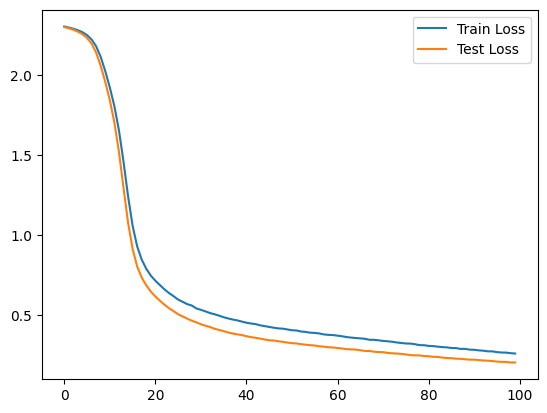

In [5]:
# Визуализация результатов обучения
sns.lineplot(train_loss, label='Train Loss')
sns.lineplot(test_loss, label='Test Loss')
plt.legend()
plt.show()



In [6]:
# Оценка модели на тестовой выборке с использованием classification report
model.eval()
all_preds = []
all_labels = []

for X, y in test_dataloader:
    predictions = model(X).detach().numpy()
    labels = y.numpy()
    all_preds.append(np.argmax(predictions, axis=1))
    all_labels.append(labels)

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

report = classification_report(all_labels, all_preds)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       978
           1       0.98      0.98      0.98      1132
           2       0.93      0.92      0.93      1030
           3       0.95      0.92      0.94      1009
           4       0.92      0.95      0.94       980
           5       0.95      0.92      0.93       890
           6       0.93      0.96      0.94       957
           7       0.96      0.92      0.94      1026
           8       0.92      0.92      0.92       973
           9       0.91      0.92      0.92      1009

    accuracy                           0.94      9984
   macro avg       0.94      0.94      0.94      9984
weighted avg       0.94      0.94      0.94      9984

